# Using CellTool
I got the package working as far as I can tell. Had to replace freeimage dependency with Pillow for image reading in ./utility/image.py, and just commented out freeimage dependency in ./command_line/match_files.py which has yet to come back to haunt me.

In ./utility/datafile.py, line 82 goes `f = open(filename, 'rU')` but the `'rU'` mode is deprecated so this is replaced with `'r'`.

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
from celltool import simple_interface as ct
from pathlib import Path
from natsort import natsorted
import pandas as pd
from celltool.contour import contour_class
from tqdm.notebook import tqdm
import pickle
import monolayer_tracking.celltool_parallel as ctp

plt.style.use('dark_background')

## Prepare Contours

In [2]:
def export_smoothed_contours(input_path, output_path=None, chunk_kwargs={}, scale=0.3225, units='\N{MICRO SIGN}m', n_resample=100, smoothing=0.007, verbose=False):
    if verbose:
        def vprint(obj):
            print(obj)
    else:
        def vprint(obj):
            pass
        
    if not output_path: # generate a corresponding output path if not specified
        output_path=input_path.replace('segmented','contours')
    print(f'opening {input_path}')
    contours=[]
    vprint('loading contours')
    segmented_files=natsorted(glob(f'{input_path}/*seg.npy'))
    for segmented_file in segmented_files:
        outlines_list = np.load(segmented_file, allow_pickle=True).item()['outlines_list']
        for cell_number, outline in enumerate(outlines_list):
            if len(outline)==0:
                continue
            contour=contour_class.Contour(points=outline)
            contour._filename=f'{output_path}{Path(segmented_file).stem[:-4]}-{cell_number}.contour' # format: '$stage_number-membrane-$timepoint-$cell_number.contour'
            contours.append(contour)
    
    vprint(f'created {len(contours)} contours')
    
    vprint('rescaling contours')
    scaled_contours=ctp.transform_contours_parallel(contours, scale_factor=scale, units=units, chunk_kwargs=chunk_kwargs)

    # resample contours
    vprint('resampling contours')
    smoothed_contours=ctp.resample_contours_parallel(scaled_contours, resample_points=n_resample, smoothing=smoothing, chunk_kwargs=chunk_kwargs) # this one is the computational bottleneck: 541 contours, ~2 minutes
    
    # export contours
    vprint('exporting contours')
    Path(output_path).mkdir(parents=True, exist_ok=True) # create export folder
    contours_dir=f'{output_path}/smoothed_contours.pkl'
    with open(contours_dir, 'wb') as file:
        pickle.dump(smoothed_contours, file) 
    print(f'completed {output_path}')

In [6]:
#segmented_stages=natsorted(glob(r'F:\my_data\Segmentation\20240221 FUCCI halo col_glass\segmented\*'))
segmented_stages=natsorted(glob(r'C:\Users\Andy\Desktop\FUCCI_nuclei\segmented\*'))

In [8]:
progress=tqdm([segmented_stages[-1]])
for stage_dir in progress:
    progress.set_description(Path(stage_dir).stem)
    export_smoothed_contours(stage_dir, output_path=None, verbose=True, chunk_kwargs=dict(size=100))

  0%|          | 0/1 [00:00<?, ?it/s]

opening C:\Users\Andy\Desktop\FUCCI_nuclei\segmented\stage_20
loading contours
created 82494 contours
rescaling contours


  0%|          | 0/825 [00:00<?, ?it/s]

resampling contours


  0%|          | 0/825 [00:00<?, ?it/s]

exporting contours
completed C:\Users\Andy\Desktop\FUCCI_nuclei\contours\stage_20


In [41]:
# import segmentation data as contours-DESKTOP

destination = 'testPCA_JulyPDMS_stage21/'
Path(destination).mkdir(parents=True, exist_ok=True)

segmented_stages=natsorted(glob('C:/Users/Andy/Desktop/20230728 halo PDMS lines incubator/segmented/stage*'))
contours=[]
contour_paths=[]

for stage_path in [segmented_stages[20]]:
    segmented_files=natsorted(glob(stage_path+'/*seg.npy'))
    for segmented_file in tqdm(segmented_files):
        outlines_list = np.load(segmented_file, allow_pickle=True).item()['outlines_list']
        for cell_number, outline in enumerate(outlines_list):
            if len(outline)==0:
                continue
            contour=contour_class.Contour(points=outline)
            contour._filename=f'{destination}{Path(segmented_file).stem[:-4]}-{cell_number}.contour'
            contours.append(contour)
            contour_paths.append(contour._filename)

print(f'created {len(contours)} contours')

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:02<00:00, 46.20it/s]

created 67934 contours


In [25]:
# rescale contours to physical units
scale = 0.3225
units = '\N{MICRO SIGN}m'

scaled_contours=ct.transform_contours(contours, scale_factor=scale, units=units, show_progress=False)

# resample contours
num_resampled_points = 100
smoothing = 0.007 # they say 1/100th the dimension of the cell is a good reference scale but idk how they computed that. They use 0.001 in the example and my cells are ~10x bigger across. Tweaking until I get a good result in the cell below.

smoothed_contours=ct.resample_contours(scaled_contours, num_resampled_points, smoothing, show_progress=False) # this one is the computational bottleneck: 541 contours, ~2 minutes

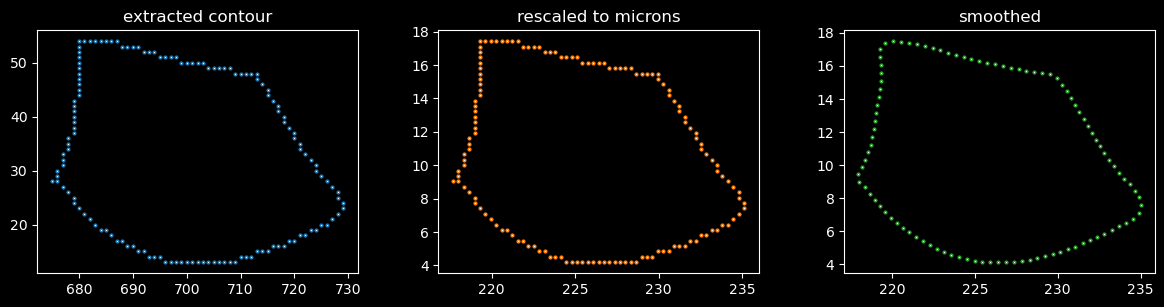

In [26]:
# visual demo: smoothing
fig, axes = plt.subplots(1,3, figsize=(12,3), subplot_kw={'aspect':1})

q_cmap=plt.cm.tab10(np.arange(3))

axes[0].scatter(*contours[0].points.T, ec=q_cmap[0], fc='white', s=4)
axes[1].scatter(*scaled_contours[0].points.T, ec=q_cmap[1], fc='white', s=4)
axes[2].scatter(*smoothed_contours[0].points.T, ec=q_cmap[2], fc='white', s=4)

axes[0].set_title('extracted contour')
axes[1].set_title('rescaled to microns')
axes[2].set_title('smoothed')

fig.tight_layout()
plt.savefig('testPCA_JulyPDMS_stage21/contours_smoothed.jpg', dpi=300)
plt.show()

In [41]:
# export contours
#ct.save_contours(smoothed_contours, contour_paths) # slow and saves individual files. pickle is ~100x faster for 500 files, perhaps faster still for more.
contours_dir='testPCA_JulyPDMS_stage21/smoothed_contours.pkl'
with open(contours_dir, 'wb') as file: 
    # A new file will be created 
    pickle.dump(smoothed_contours, file) 

## Align Contours

In [2]:
def export_aligned_contours(input_path, reference_contour=None, allow_reflection=True, chunk_kwargs={}):
    smoothed_contour_dir=input_path+'/smoothed_contours.pkl'
    with open(smoothed_contour_dir, 'rb') as file: 
        smoothed_contours = pickle.load(file)
    print(f'loaded {len(smoothed_contours)} contours')
    
    print('aligning contours')
    aligned_contours=ctp.align_contours_to_parallel(smoothed_contours, reference=reference_contour, chunk_kwargs=chunk_kwargs, allow_reflection=allow_reflection)
    
    print('exporting contours')
    aligned_dir=input_path+'/aligned_contours.pkl'
    with open(aligned_dir, 'wb') as file: 
        pickle.dump(aligned_contours, file)

In [3]:
from monolayer_tracking.celltool_parallel import export_aligned_contours

In [4]:
contour_dirs=natsorted(glob(r'C:\Users\Andy\Desktop\FUCCI_nuclei\contours\*'))
with open(contour_dirs[0]+'/smoothed_contours.pkl', 'rb') as file: 
    smoothed_contours = pickle.load(file)
print(len(smoothed_contours))

84586


In [ ]:
def sample_reference_contour(smoothed_contours, sample_size=2000):
    aligned_contours=ctp.align_contours_parallel(np.random.choice(smoothed_contours, size=sample_size), chunk_kwargs={'size':100}, concat=False)

    mean_contours=[]
    for contours in tqdm(aligned_contours):
        pca_contour=ct.make_shape_model(contours, required_variance_explained=0.95)[0]
        mean_contours.append(pca_contour)
    mean_contours=ct.align_contours(mean_contours)
    reference_contour=ct.make_shape_model(mean_contours, required_variance_explained=0.95)[0]
    
    return reference_contour

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

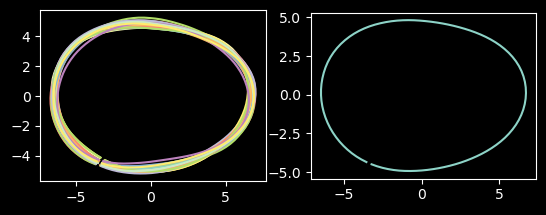

In [5]:
# generate a reference contour by sampling the contours

aligned_contours=ctp.align_contours_parallel(np.random.choice(smoothed_contours, size=2000), chunk_kwargs={'size':100}, concat=False)

fig, axes=plt.subplots(1,2, subplot_kw={'aspect':1})
mean_contours=[]
for contours in tqdm(aligned_contours):
    pca_contour=ct.make_shape_model(contours, required_variance_explained=0.95)[0]
    #axes[0].plot(*pca_contour.points.T)
    mean_contours.append(pca_contour)

mean_contours=ct.align_contours(mean_contours)
for contour in mean_contours:
    axes[0].plot(*contour.points.T)
reference_contour=ct.make_shape_model(mean_contours, required_variance_explained=0.95)[0]
axes[1].plot(*reference_contour.points.T)
plt.show()

In [6]:
smoothed_contour_dir=contour_dirs[23]+'/smoothed_contours.pkl'
with open(smoothed_contour_dir, 'rb') as file: 
    smoothed_contours = pickle.load(file)

In [17]:
for contour in tqdm(smoothed_contours):
    # if shape is (100,2), continue. Otherwise raise an error.
    if not np.array_equal(contour.points.shape, (100,2)):
        raise ValueError('Contour has incorrect shape')

  0%|          | 0/103789 [00:00<?, ?it/s]

In [23]:
smoothed_contours[28793].points.shape

(100, 2)

In [21]:
for contour in tqdm(smoothed_contours[28793:28792+8]):
    ct.align_contours_to([contour], reference_contour, allow_reflection=True)

  0%|          | 0/7 [00:00<?, ?it/s]

TypeError: Cannot align point-sets in different dimensions, or with different numbers of points.

In [20]:
smoothed_contours[28793].points.shape

(100, 2)

In [6]:
#contour_dirs=natsorted(glob(r'F:\my_data\Segmentation\20240221 FUCCI halo col_glass\contours\*'))

for contour_dir in tqdm(contour_dirs):
    print(contour_dir)
    export_aligned_contours(contour_dir, reference_contour, chunk_kwargs=dict(size=8))

  0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\Andy\Desktop\FUCCI_nuclei\contours\stage_2
loaded 84586 contours
aligning contours


  0%|          | 0/10574 [00:00<?, ?it/s]

exporting contours
C:\Users\Andy\Desktop\FUCCI_nuclei\contours\stage_20
loaded 82494 contours
aligning contours


  0%|          | 0/10312 [00:00<?, ?it/s]

exporting contours


In [8]:
# load contours - can skip if you're working with the same smoothed_contours as above
#contour_paths=natsorted(glob('testPCA_JulyPDMS_stage21_firstframe/Contours/*.contour')) # change this
#smoothed_contours=ct.load_contours(contour_paths)

contours_dir='PCA/JulyPDMS_stage21/smoothed_contours.pkl'

with open(contours_dir, 'rb') as file: 
    # Call load method to deserialze 
    smoothed_contours = pickle.load(file) 

print(f'loaded {len(smoothed_contours)} contours') 

loaded 67934 contours


In [28]:
allow_reflection=True

# align without specified reference contour
#aligned_contours=ct.align_contours(smoothed_contours, allow_reflection=allow_reflection) # this is also slow (probably >2min) but I haven't timed it.

# align to reference contour (faster than computing a mean contour, which requires multiple iterations of alignment. Compare at 30s but may scale up further for large datasets)
reference_contour=contour_class.from_file('testPCA_JulyPDMS_stage21_firstframe/PCA model.contour')
aligned_contours=ct.align_contours_to(smoothed_contours, reference_contour, allow_reflection=allow_reflection)

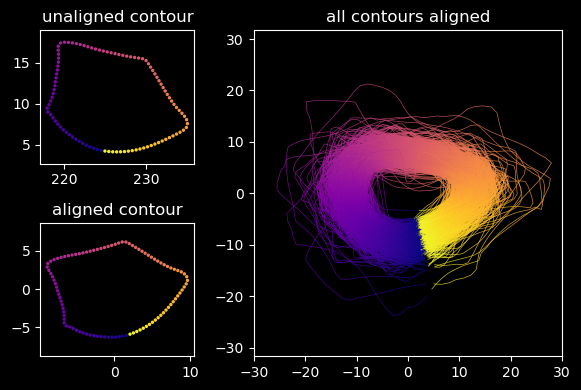

In [508]:
# visual demo
from matplotlib.collections import LineCollection

def plot_multicolored_line(x, y, ax, c, **kwargs):
    points = np.array([x, y]).T.reshape(-1, 1, 2).reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create a continuous norm to map from data points to colors
    lc = LineCollection(segments, **kwargs)
    # Set the values used for colormapping
    lc.set_array(np.linspace(0,1,100))
    line = ax.add_collection(lc)

fig, ax_dict = plt.subplot_mosaic([['unaligned', 'super'],
                                   ['aligned', 'super']],
                                  figsize=(6,4),
                                  gridspec_kw={'width_ratios':[1,2]},
                                  subplot_kw={'aspect':1, 'adjustable':'datalim'}
                                 )
    
ax_dict['unaligned'].scatter(*smoothed_contours[0].points.T, s=2, cmap='plasma', c=np.linspace(0,1,len(smoothed_contours[0].points)))
ax_dict['aligned'].scatter(*aligned_contours[0].points.T, s=2, cmap='plasma', c=np.linspace(0,1,len(smoothed_contours[0].points)))

for c in aligned_contours:
    plot_multicolored_line(*c.points.T, ax_dict['super'], np.linspace(0,1,len(smoothed_contours[0].points)), cmap='plasma', alpha=0.8, linewidths=0.5) 

ax_dict['super'].set_xlim(-30, 30)
ax_dict['super'].set_ylim(-25, 25)

ax_dict['unaligned'].set_title('unaligned contour')
ax_dict['aligned'].set_title('aligned contour')
ax_dict['super'].set_title('all contours aligned')

fig.tight_layout()
plt.savefig('testPCA_JulyPDMS21/contours_aligned.jpg', dpi=300)
plt.show()

In [40]:
# export aligned contours
aligned_dir='testPCA_JulyPDMS_stage21/aligned_contours.pkl'
with open(aligned_dir, 'wb') as file: 
    # A new file will be created 
    pickle.dump(aligned_contours, file) 

## Contour PCA

In [20]:
# can skip this if coming from above
#aligned_contour_paths=natsorted(glob('testPCA_JulyPDMS_stage21_firstframe/Aligned/*.contour'))

#aligned_contours=ct.load_contours(aligned_contour_paths)

aligned_dir='testPCA_JulyPDMS_stage21/aligned_contours.pkl'

with open(aligned_dir, 'rb') as file: 
    # Call load method to deserialze 
    aligned_contours = pickle.load(file) 

print(f'loaded {len(aligned_contours)} contours') 

loaded 541 contours


In [6]:
aligned_contour_dirs=natsorted(glob(r'F:\my_data\Segmentation\20240221 FUCCI halo col_glass\contours\*\aligned_contours.pkl'))

aligned_contours=[]
for contour_dir in tqdm(aligned_contour_dirs):
    with open(contour_dir, 'rb') as file:
        aligned_contours.extend(pickle.load(file))

print(f'loaded {len(aligned_contours)} contours') 

  0%|          | 0/23 [00:00<?, ?it/s]

loaded 2160644 contours


In [52]:
variance_explained=0.95
pca_contour, header, rows, norm_header, norm_rows = ct.make_shape_model(aligned_contours, required_variance_explained=variance_explained)

In [53]:
# export PCA model and positions
pca_contour.to_file('PCA/JD_2mgcol/PCA model.contour')
fit_export='PCA/JD_2mgcol/PCA-positions.csv'
fit_normalized_export='PCA/JD_2mgcol/PCA-normalized-positions.csv'

pd.DataFrame(rows, columns=header).to_csv(fit_export, index=False)
pd.DataFrame(norm_rows, columns=norm_header).to_csv(fit_normalized_export, index=False)

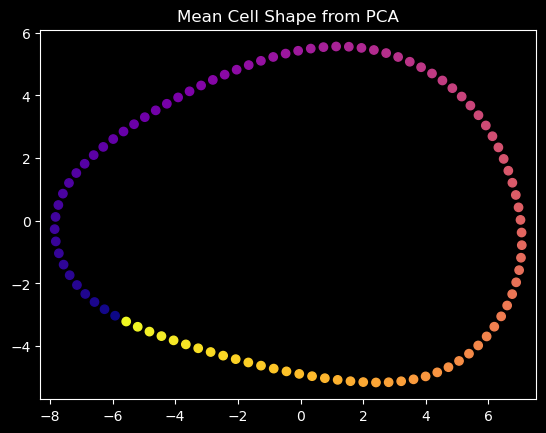

In [54]:
# show mean
plt.title('Mean Cell Shape from PCA')
plt.scatter(*pca_contour.points.T, cmap='plasma', c=np.linspace(0,1,len(pca_contour.points)))
plt.axis('equal')

plt.savefig('PCA/JD_2mgcol/PCA_mean.jpg', dpi=300)
plt.show()

In [55]:
# compute mode stdevs
num_total_modes=len(pca_contour.modes)
modes=np.arange(num_total_modes) # or some subset of the modes which we want to plot

positions = np.array([-3, -2, -1, 0, 1, 2, 3])

mode_contours = []
EVRs = []
for mode in modes:
    inner_contours = []
    for position in positions:
        pos = np.zeros(num_total_modes)
        pos[mode] = position
        inner_contours.append(pca_contour.as_position(pos, normalized = True))
        
    mode_contours.append(inner_contours)
    EVRs.append(pca_contour.standard_deviations[mode]**2/pca_contour.total_variance)

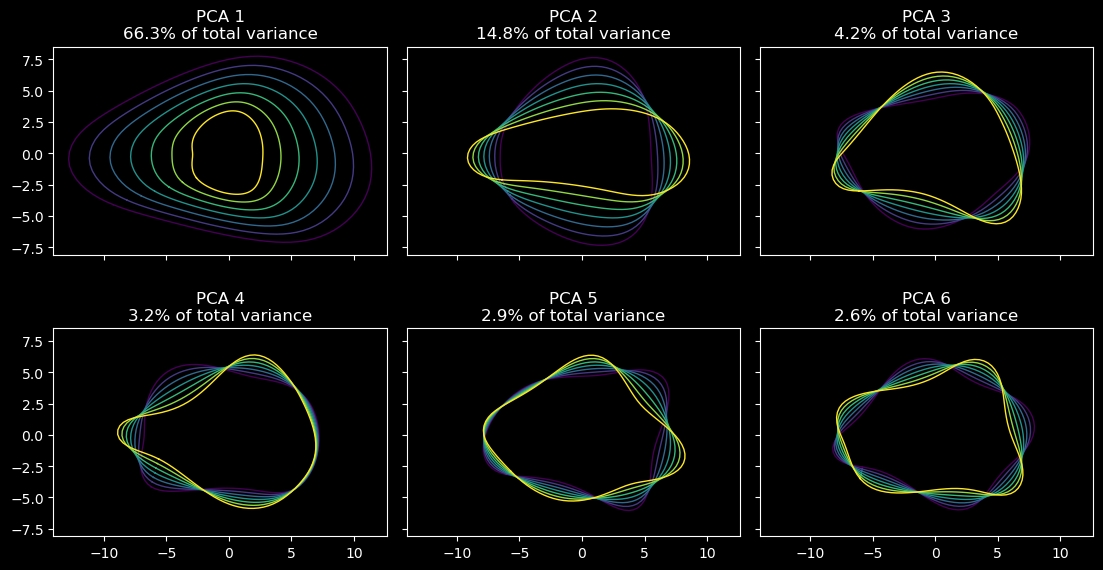

In [56]:
colors = plt.cm.viridis(np.linspace(0, 1, len(positions)))

fig, axes = plt.subplots(2,3, figsize=(11,6), subplot_kw={'aspect':1}, sharex=True, sharey=True)

for n, EVR, mode_contour, ax in zip(modes, EVRs, mode_contours, axes.flatten()):
    for c, color in zip(mode_contour, colors):
        x, y=np.append(c.points, [c.points[0]], axis=0).T
        ax.plot(x, y, color=color, linewidth=1)
    ax.set_title(f'PCA {n+1}\n{EVR*100:.1f}% of total variance')

fig.tight_layout()
plt.savefig('PCA/JD_2mgcol/PCA_modes.jpg', dpi=300)
plt.show()